# 浅井ゼミ ゼミ対抗論文大会
---
## アンケート結果分析
---
- 創価大学に所属する学生に学内ローソンにおける行列に関するアンケートを行い，そのデータに基づいて分析をしていく．
- 有効回答数 : 412（仮）

## 概略
---
### データ成形
- アンケートにある質問から，有効なデータだけを切り取り，分析可能な数値データに変換する
- 各分析手法にマッチしたラベル，特徴量の作成を行う．

### 分析手法
- 主成分分析
- カーネル主成分分析; カーネルトリック
- 因子分析
    - 主成分分析における共分散行列の固有値，固有ベクトルを使用し，因子負荷量を算出し，主成分の意味を考察する
- ロジスティック回帰
- サポートベクターマシン
- ガウスカーネルサポートベクターマシン
- 決定木学習

### 分析概要
- 分類問題の目標は，「電子マネーを使う/使わない」，「キャッシュレス決済を使う/使わない」
- 分類問題を解く際に，モデルの使い分けと，分析の容易さを考慮して，3種類のラベルデータを3つの手法に分けて分析を行う


- 1. キャッシュレス決済を使用したことがあり，電子マネーを持っている人 / キャッシュレス決済を使用したことがないかつ電子マネーを持っている人の2値分類

- 2. キャッシュレス決済を使用したことがあり，電子マネーを持っていない人 / 電子マネーを持っていない人の2値分類

- 3. キャッシュレス決済を使用したことがあり，電子マネーを持っている人 / キャッシュレス決済を使用したことがないかつ電子マネーを持っている人 / 電子マネーを持っていない人の3値多クラス分類


In [1]:
import sklearn
import seaborn
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from matplotlib import font_manager 
from sklearn import preprocessing

%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

In [2]:
# データ読み込み
df = pd.read_csv("./questionnaire.csv")

## ラベルデータの作成
---

In [3]:
# まずタイムスタンプのデータは必要ないので，削除
df = df.drop("タイムスタンプ", axis=1)
# NaNデータも取り除く
df = df.dropna(how='all')
df = df.drop(9, axis=0) # 謎，削除

In [4]:
df["学内ローソンでキャッシュレス決済を利用したことがありますか？"].unique()

array(['YES.', 'NO.'], dtype=object)

In [5]:
# キャッシュレス決済を利用した事がない人
not_cashless = df[df["学内ローソンでキャッシュレス決済を利用したことがありますか？"] == 'NO.']
# キャッシュレス決済を利用したことがある人
cashless = df[df["学内ローソンでキャッシュレス決済を利用したことがありますか？"] == 'YES.']


- キャッシュレス決済を使用したことがあり，電子マネーを持っている人
- キャッシュレス決済を使用したことがなく，電子マネーを持っている人

の二値分類の場合と

- キャッシュレス決済を使用したことがあり，電子マネーを持っていない人
- 電子マネーを持っていない人

の二値分類の場合と

- 三値分類の場合

に分けて分類問題を解いていく．


In [6]:
# キャッシュレス決済を使用したことがあり，電子マネーを持っている人
emoney_and_cashless = cashless[df["よく利用する支払い方法は以下のうちどれですか？"].notnull()]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [7]:
# キャッシュレス決済を使用したことがないかつ電子マネーを持っている
emoney_but_not_cashless = not_cashless[df["キャッシュレス決済を利用しない理由は何ですか？"] == '2. キャッシュレス決済手段を持っているが、利用していない']

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [8]:
# 電子マネーを持っていない人
not_emoney_and_not_cashless = not_cashless[df["キャッシュレス決済を利用しない理由は何ですか？"] == '1. キャッシュレス決済手段を持っていない']

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


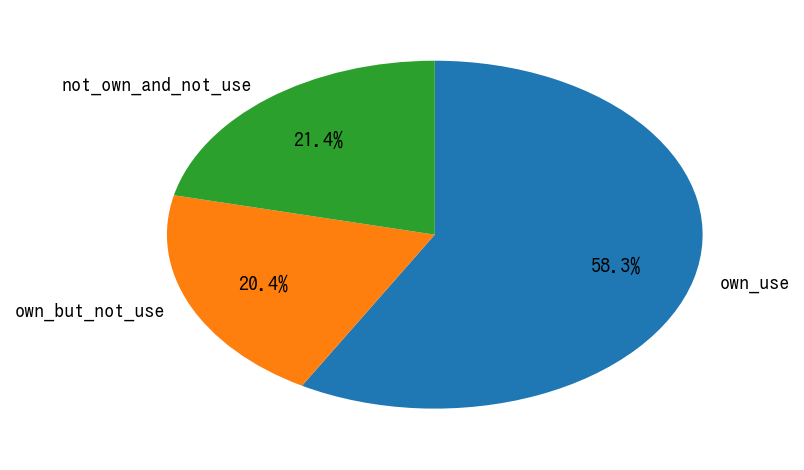

In [9]:
# 配列作成
x_pie = [len(emoney_and_cashless), len(emoney_but_not_cashless), len(not_emoney_and_not_cashless)]
label_pie = ["own_use", "own_but_not_use", "not_own_and_not_use"]

plt.pie(x_pie, labels=label_pie, counterclock=False, startangle=90, autopct="%.1f%%",
        pctdistance=0.7)

plt.show()

[キャッシュレス決済を使用したことがあり，電子マネーを持っている人,

キャッシュレス決済を使用したことがないかつ電子マネーを持っている人,

電子マネーを持っていない人]

を[0,1,2]に変換

In [10]:
for index, line in enumerate([emoney_and_cashless.index.values, emoney_but_not_cashless.index.values, not_emoney_and_not_cashless.index.values]):
    for n in line:
        df.at[n, "キャッシュレス決済を利用しない理由は何ですか？"] = index

- ここで分析ごとに分けてデータフレームを作成し，データ整形していく

In [11]:
# 分析1
df1 = df
# ここで無意味なデータを削除する
df1 = df1.drop("その理由は何ですか？", axis=1)
df1 = df1.drop("なぜクレジットカードを持っていないのですか？（複数選択可）", axis=1)
df1 = df1.drop("デビットカードを知っていますか？", axis=1)
df1 = df1.drop("学内ローソンでキャッシュレス決済を利用したことがありますか？", axis=1)

In [12]:
# 分析1では，0と1のみのラベルで分類をするので，ラベルが2のデータを削除
df1 = df1[df1["キャッシュレス決済を利用しない理由は何ですか？"] != 2]

In [13]:
# 分析1のラベルデータの格納
y1 = df1["キャッシュレス決済を利用しない理由は何ですか？"].values
y1

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0,

In [14]:
# 分析2
df2 = df
# ここで無意味なデータを削除する
df2 = df2.drop("その理由は何ですか？", axis=1)
df2 = df2.drop("なぜクレジットカードを持っていないのですか？（複数選択可）", axis=1)
df2 = df2.drop("デビットカードを知っていますか？", axis=1)
df2 = df2.drop("学内ローソンでキャッシュレス決済を利用したことがありますか？", axis=1)

In [15]:
# 分析2では，0と2のみのラベルで分類をするので，ラベルが1のデータを削除
df2 = df2[df2["キャッシュレス決済を利用しない理由は何ですか？"] != 1]
df2 = df2.replace(2, 1)

In [16]:
# 分析2のラベル格納
y2 = df2["キャッシュレス決済を利用しない理由は何ですか？"].values
y2

array([0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,

In [17]:
# 分析3
df3 = df
# ここで無意味なデータを削除する
df3 = df3.drop("その理由は何ですか？", axis=1)
df3 = df3.drop("なぜクレジットカードを持っていないのですか？（複数選択可）", axis=1)
df3 = df3.drop("デビットカードを知っていますか？", axis=1)
df3 = df3.drop("学内ローソンでキャッシュレス決済を利用したことがありますか？", axis=1)

In [18]:
# 分析3では3値分類を行うため，そのまま格納
y3 = df3["キャッシュレス決済を利用しない理由は何ですか？"].values
y3

array([0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 2,
       2, 0, 0, 2, 0, 0, 0, 0, 1, 2, 1, 2, 0, 1, 0, 1, 2, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 2, 1, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0,
       1, 0, 2, 2, 0, 0, 1, 0, 0, 1, 0, 2, 0, 0, 2, 0, 0, 2, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 1, 0, 2, 0, 1, 0, 0, 0, 2,
       0, 1, 2, 0, 0, 1, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 2, 1, 2, 0, 0, 1, 1, 0, 0, 0, 2, 2, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 2, 1, 2, 2, 2, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 2, 0, 1, 0, 2, 0, 2, 0, 2, 2, 0, 0, 2, 0, 2, 2, 0, 0, 1,
       0, 0, 0, 2, 0, 0, 1, 0, 1, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 1, 0, 0,
       1, 2, 2, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 2, 2, 1, 0, 2, 1, 2,
       1, 0, 0, 0, 0, 1, 2, 2, 1, 0, 2, 1, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 2, 1, 0, 1, 1, 0, 0, 2, 1, 0, 2, 0, 0, 1, 0, 0, 2, 0,
       0, 0, 2, 0, 0, 0, 2, 1, 0, 0, 1, 0, 0, 0, 0,

- **これで各分析におけるラベルデータの格納が完了(y1, y2, y3)**

In [19]:
len(y3)

412

In [20]:
df.head()

,あなたの学部は何ですか？,並んでいる列を見て買うことを断念することはありますか？,店員に用意してもらう商品（Lチキやカフェラテなど）をどのくらいの頻度で頼みますか？,ローソンの有人レジでもキャッシュレス決済ができることは知っていますか？,学内ローソンでキャッシュレス決済を利用したことがありますか？,よく利用する支払い方法は以下のうちどれですか？,キャッシュレス決済を利用しない理由は何ですか？,その理由は何ですか？,あなたはクレジットカードを持っていますか？,なぜクレジットカードを持っていないのですか？（複数選択可）,デビットカードを知っていますか？
0,NaN,よくある,ほぼ買わない,NaN,YES.,電子マネー（交通系）,0,NaN,YES,NaN,はい、仕組みについても知っています。
2,NaN,よくある,３割程度,NaN,YES.,バーコード決済,0,NaN,YES,NaN,はい、仕組みについても知っています。
3,NaN,よくある,ほぼ買わない,NaN,YES.,バーコード決済,0,NaN,YES,NaN,知っているけど、仕組みまでは分かりません。
4,NaN,たまにある,３割程度,NaN,NO.,NaN,2,NaN,NO,危険だという認識があるから。,知っているけど、仕組みまでは分かりません。
7,経済学部,よくある,ほぼ買わない,NaN,YES.,電子マネー（交通系）,0,NaN,YES,NaN,はい、仕組みについても知っています。


## 特徴量行列の作成
---

In [21]:
# ここで無意味なデータを削除する
df = df.drop("その理由は何ですか？", axis=1)
df = df.drop("なぜクレジットカードを持っていないのですか？（複数選択可）", axis=1)
df = df.drop("デビットカードを知っていますか？", axis=1)
df = df.drop("学内ローソンでキャッシュレス決済を利用したことがありますか？", axis=1)

In [22]:
df["ローソンの有人レジでもキャッシュレス決済ができることは知っていますか？"].unique()

array([nan, 'NO.', 'YES.'], dtype=object)

In [23]:
df["あなたはクレジットカードを持っていますか？"].unique()

array(['YES', 'NO'], dtype=object)

In [24]:
df = df.replace(list(df["あなたの学部は何ですか？"].unique()), [0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0])
df = df.replace(list(df["並んでいる列を見て買うことを断念することはありますか？"].unique()),[1, 1, 0])
df = df.replace(list(df["店員に用意してもらう商品（Lチキやカフェラテなど）をどのくらいの頻度で頼みますか？"].unique()),[0, 1, 1, 1, 0, 0, 1])
df = df.replace(list(df["ローソンの有人レジでもキャッシュレス決済ができることは知っていますか？"].unique()),[0, 0, 1])
df = df.replace(list(df["あなたはクレジットカードを持っていますか？"].unique()),[1, 0])

In [25]:
df["よく利用する支払い方法は以下のうちどれですか？"].unique()

array(['電子マネー（交通系）', 'バーコード決済', 0, '電子マネー', 'クレジットカード', 'デビットカード',
       '電子マネー（交通系）;クレジットカード;バーコード決済', '電子マネー（交通系）;クレジットカード',
       '電子マネー;電子マネー（交通系）;クレジットカード', '電子マネー（交通系）;デビットカード',
       '電子マネー;電子マネー（交通系）', 'クレジットカード;デビットカード', 'ブランドプリペイドカード',
       '電子マネー;クレジットカード',
       '電子マネー;電子マネー（交通系）;クレジットカード;JCBプレモカード;ブランドプリペイドカード;デビットカード',
       '電子マネー;クレジットカード;デビットカード', 'クレジットカード;バーコード決済', '電子マネー（交通系）;バーコード決済',
       '電子マネー;電子マネー（交通系）;クレジットカード;デビットカード', '電子マネー（交通系）;クレジットカード;デビットカード'],
      dtype=object)

In [26]:
means_payment = {}
for line in df["よく利用する支払い方法は以下のうちどれですか？"].unique():
    if line != 0:
        l = line.split(";")
        means_payment[line] = l
    else:
        means_payment[line] = line


# means_paymentの整理
for k, v in means_payment.items():
    l = []
    if v == 0:
        pass
    else:
        for m in v:
            if m == '電子マネー（交通系）' or m == 'ブランドプリペイドカード':
                l.append(2)
            if m == '電子マネー':
                l.append(1)
            if m == 'バーコード決済':
                l.append(5)
            if m == 'クレジットカード' or m == 'JCBプレモカード':
                l.append(3)
            if m == 'デビットカード':
                l.append(4)
        means_payment[k] = l

In [27]:
means_payment

{'電子マネー（交通系）': [2],
 'バーコード決済': [5],
 0: 0,
 '電子マネー': [1],
 'クレジットカード': [3],
 'デビットカード': [4],
 '電子マネー（交通系）;クレジットカード;バーコード決済': [2, 3, 5],
 '電子マネー（交通系）;クレジットカード': [2, 3],
 '電子マネー;電子マネー（交通系）;クレジットカード': [1, 2, 3],
 '電子マネー（交通系）;デビットカード': [2, 4],
 '電子マネー;電子マネー（交通系）': [1, 2],
 'クレジットカード;デビットカード': [3, 4],
 'ブランドプリペイドカード': [2],
 '電子マネー;クレジットカード': [1, 3],
 '電子マネー;電子マネー（交通系）;クレジットカード;JCBプレモカード;ブランドプリペイドカード;デビットカード': [1,
  2,
  3,
  3,
  2,
  4],
 '電子マネー;クレジットカード;デビットカード': [1, 3, 4],
 'クレジットカード;バーコード決済': [3, 5],
 '電子マネー（交通系）;バーコード決済': [2, 5],
 '電子マネー;電子マネー（交通系）;クレジットカード;デビットカード': [1, 2, 3, 4],
 '電子マネー（交通系）;クレジットカード;デビットカード': [2, 3, 4]}

In [28]:
# pay_listに新たな特徴量を追加; 支払い方法
pay_list = pd.DataFrame({'キャッシュレス決済手段を持っていない': np.zeros(412),
                        '電子マネー': np.zeros(412),
                        'プリペイド型電子マネー': np.zeros(412),
                        'クレジットカード': np.zeros(412),
                        'デビットカード':np.zeros(412), 
                        'バーコード決済': np.zeros(412)}, 
                       index=range(412))

In [29]:
for index, line in enumerate(df["よく利用する支払い方法は以下のうちどれですか？"].values):
    if line == 0:
        pay_list.iat[index, 0] = 1
    else:
        # mean_paymentと照らし合わせながらDataFrameの値を変えていく．
        for n in means_payment[line]:
            pay_list.iat[index, n] = 1
    

In [30]:
pay_list.head()

,キャッシュレス決済手段を持っていない,電子マネー,プリペイド型電子マネー,クレジットカード,デビットカード,バーコード決済
0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0


- これで決済手段のダミー変数を使った変換が完了
- これでもとの特徴量行列に決済手段の情報は必要なくなったため，削除
- この`pay_list`をもとの特徴量行列と結合させる

In [31]:
df = df.drop("よく利用する支払い方法は以下のうちどれですか？", axis=1)

In [32]:
df.head()

,あなたの学部は何ですか？,並んでいる列を見て買うことを断念することはありますか？,店員に用意してもらう商品（Lチキやカフェラテなど）をどのくらいの頻度で頼みますか？,ローソンの有人レジでもキャッシュレス決済ができることは知っていますか？,キャッシュレス決済を利用しない理由は何ですか？,あなたはクレジットカードを持っていますか？
0,0,1,0,0,0,1
2,0,1,1,0,0,1
3,0,1,0,0,0,1
4,0,1,1,0,2,0
7,1,1,0,0,0,1


In [33]:
# 説明変数の行結合
data = []
for i in range(len(pay_list.values)):
    data.append(np.hstack([pay_list.values[i], df.values[i]]))

In [34]:
data = pd.DataFrame(data)
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0


In [35]:
# 0列目の修正
for i in range(len(data.values)):
    if data.iat[i, 10] == 1:
        data.iat[i, 0] = 0

In [36]:
X1 = data[data[10] != 2]
X1 = X1.drop(10, axis=1)
X2 = data[data[10] != 1]
X2 = X2.drop(10, axis=1)
X3 = data
X3 = X3.drop(10, axis=1)

In [37]:
X3.head()

,0,1,2,3,4,5,6,7,8,9,11
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


In [38]:
# 結合した特徴量のインデックスの設定
index_X = ['キャッシュレス決済手段を持っていない',
           '電子マネーを使う',
           'プリペイド型電子マネーを使う',
           'クレジットカードを使う',
           'デビットカードを使う',
           'バーコード決済を使う',
           '学部が中央教育棟にある', 
           '並んでいる列を見て買うことを断念することがある',
           'ホットスナックを買う',
           '有人レジでもキャッシュレス決済ができることを知っている', 
           'クレジットカードを持っている']

In [39]:
index_dict = {}
for i, name in enumerate(index_X):
    if i == 10:
        i =11
    index_dict[i] = name
    

In [40]:
X3.rename(columns=index_dict)

,キャッシュレス決済手段を持っていない,電子マネーを使う,プリペイド型電子マネーを使う,クレジットカードを使う,デビットカードを使う,バーコード決済を使う,学部が中央教育棟にある,並んでいる列を見て買うことを断念することがある,ホットスナックを買う,有人レジでもキャッシュレス決済ができることを知っている,クレジットカードを持っている
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
5,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
6,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
7,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
8,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
9,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0


In [41]:
pd.DataFrame(index_X)

,0
0,キャッシュレス決済手段を持っていない
1,電子マネーを使う
2,プリペイド型電子マネーを使う
3,クレジットカードを使う
4,デビットカードを使う
5,バーコード決済を使う
6,学部が中央教育棟にある
7,並んでいる列を見て買うことを断念することがある
8,ホットスナックを買う
9,有人レジでもキャッシュレス決済ができることを知っている


- 決定木用

In [42]:
XX = X3
index_XX = index_X

- **これで特徴量の配列も完成．(X1, X2, X3) + 決定木(XX)**

## 主成分分析と線形分離
---

### 主成分分析とは
- 学習データの分散が最大となる方向を求め，データの固有値問題を解く．
- 固有値問題をといて算出された固有値，固有ベクトルから，最大固有値を選択し，それに対応する固有ベクトルを $ a $ とする．
- 固有値を上位からk個選択し，k次元の新たな特徴部分空間を取得する

### 因子分析; 因子負荷量とは
- 因子負荷量; *loading matrix*
- 軸の意味の解釈
- 主成分と各列の相関を算出することになる．

- loading matrixは便利

> loading matrix is informative: its vertical sums of squares are the eigenvalues, components' variances, 
>
>and its horizontal sums of squares are portions of the variables' variances being "explained" by the components.



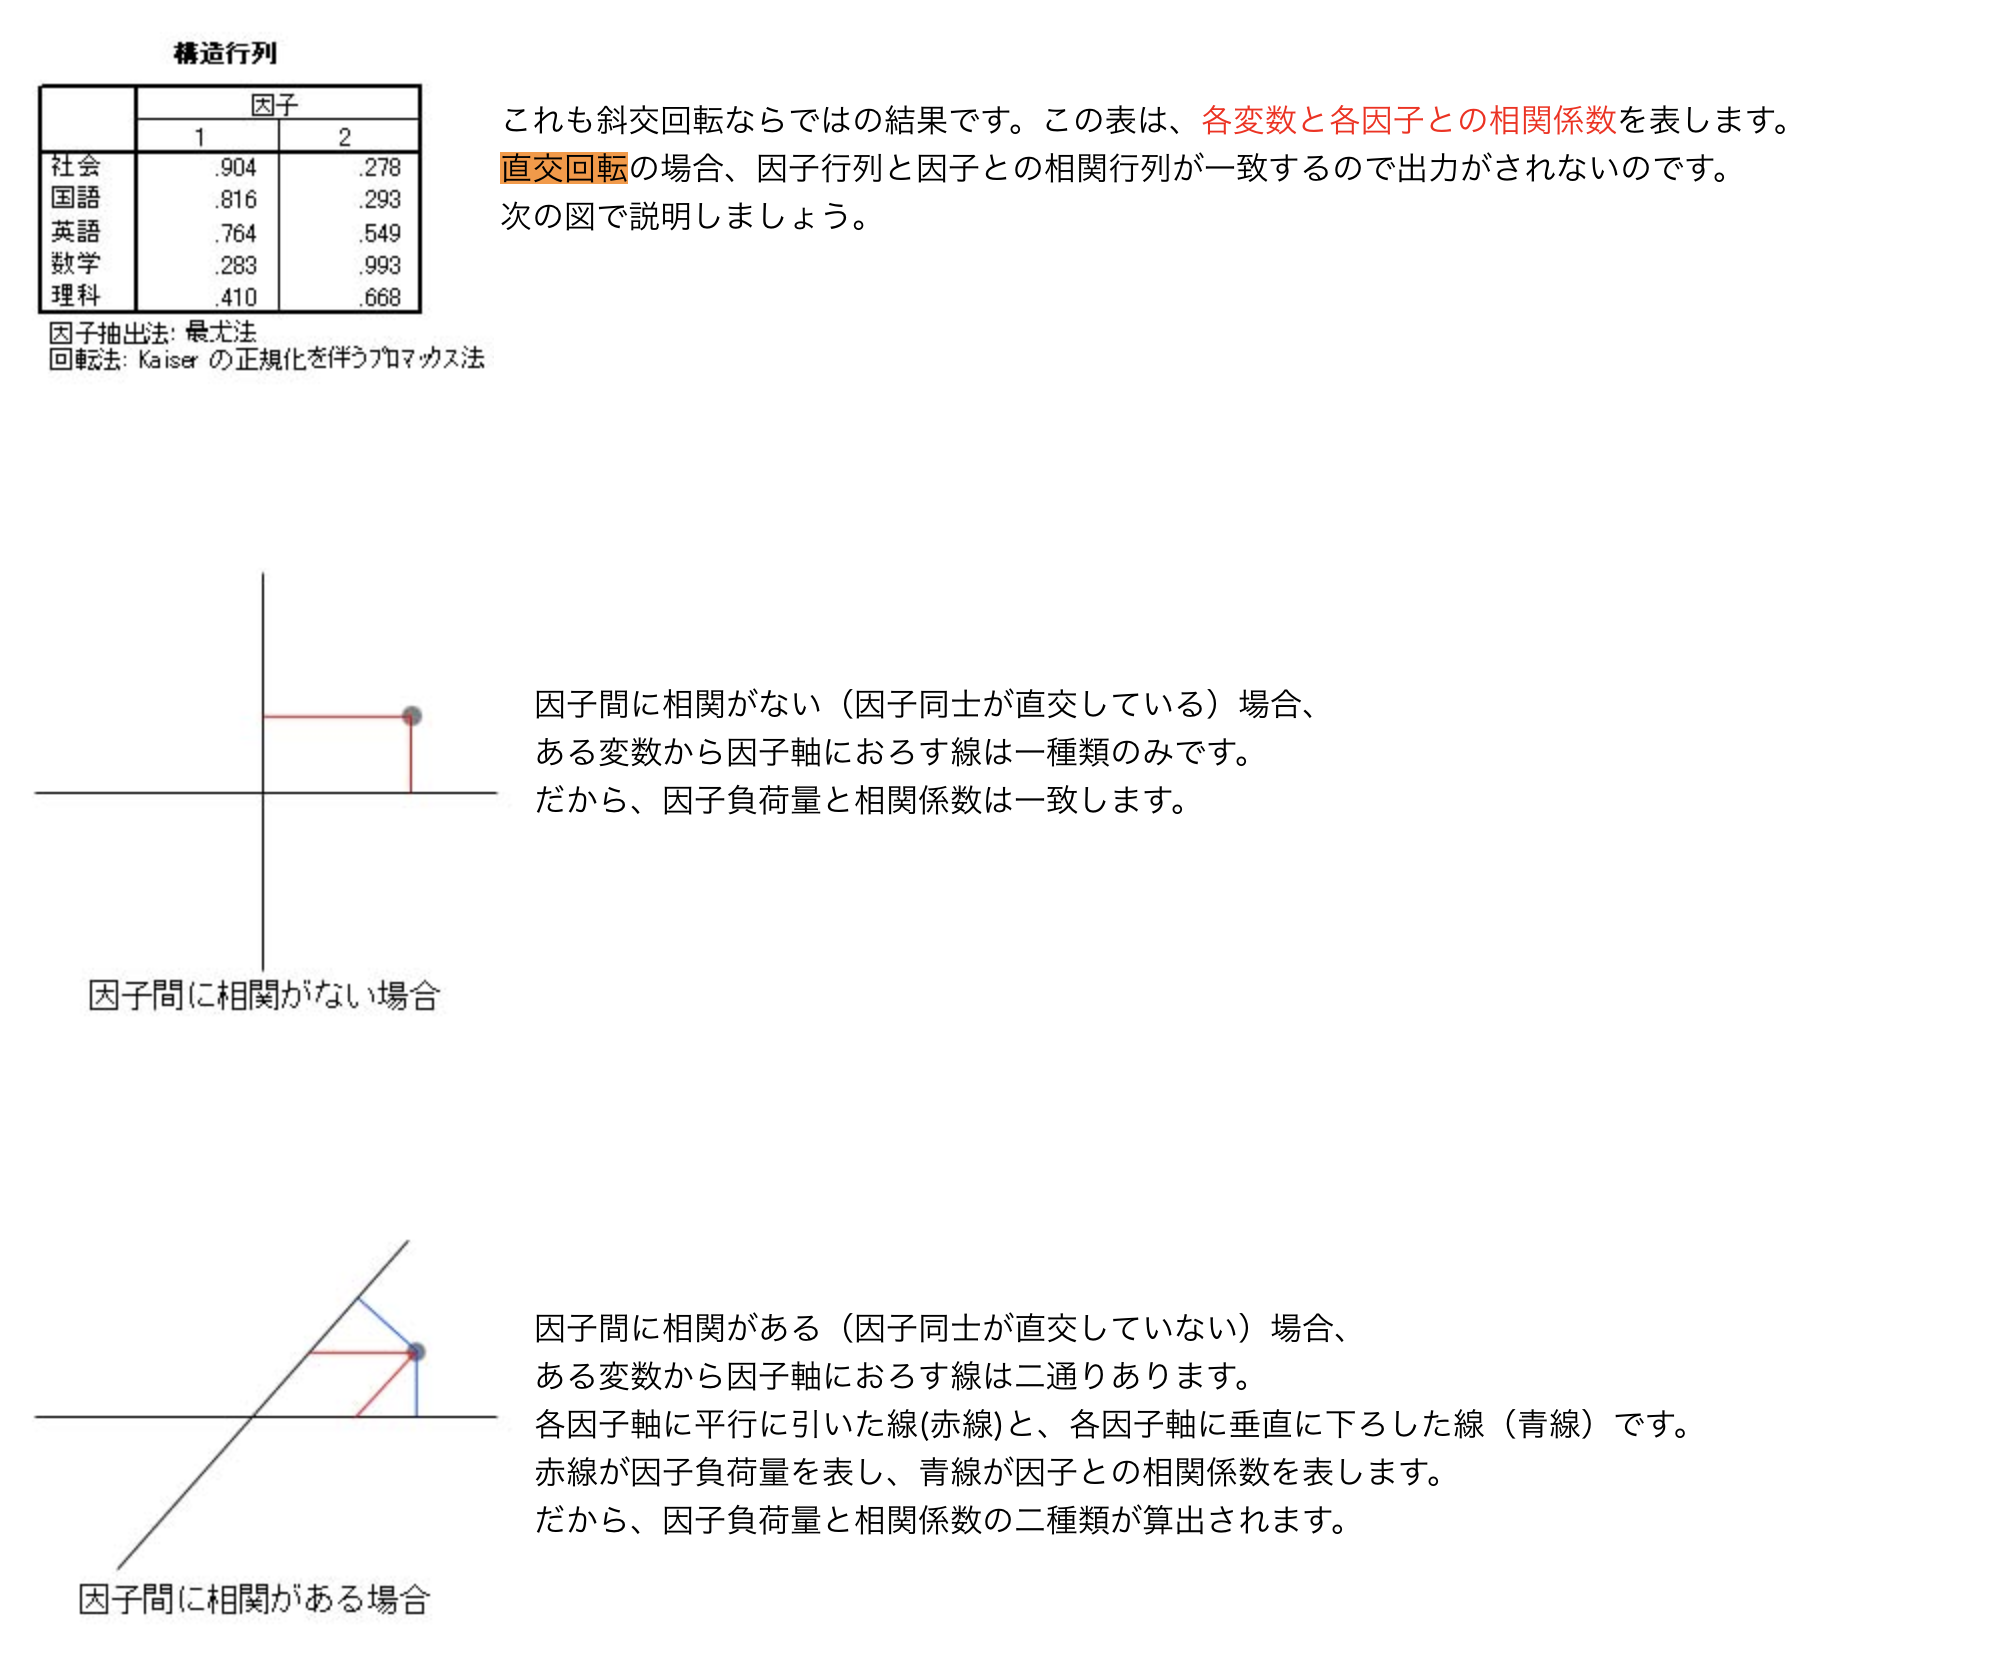

In [45]:
# 表示用
from IPython.display import Image
Image('./lm.png', width=1000, height=800)

### 分析1

In [46]:
# まずは，データの形を見てみる．
X1.head()

,0,1,2,3,4,5,6,7,8,9,11
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
5,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0


In [47]:
# 0列目は必要ないので，削除
X1 = X1.drop(0, axis=1)

In [48]:
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
data_sc_1 = sc.fit_transform(X1)
pca = PCA(n_components=2)
pca.fit(data_sc_1)

transformed1 = pca.fit_transform(data_sc_1)

Text(0,0.5,'pc2')

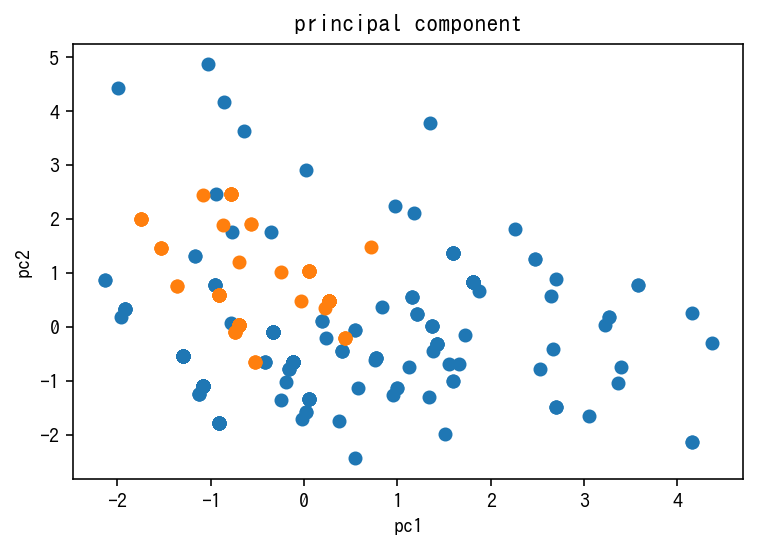

In [49]:
# 主成分をプロットする
for label in np.unique(y1):
    plt.scatter(transformed1[y1 == label, 0],
                transformed1[y1 == label, 1])
plt.title('principal component')
plt.xlabel('pc1')
plt.ylabel('pc2')

# 青がクラス1，オレンジがクラス2

In [50]:
index_X1 = index_X[1:]

In [51]:
pca.components_

array([[ 0.35934031, -0.19163103,  0.60094287,  0.34150704, -0.0422917 ,
         0.10383881, -0.15638793,  0.06774935,  0.28703571,  0.48206322],
       [-0.15591622, -0.56538679,  0.13161142, -0.15182342,  0.41791098,
        -0.26571323, -0.10244125, -0.27218579, -0.48582548,  0.22315281]])

In [52]:
np.c_[np.sqrt(pca.explained_variance_)]

array([[1.30505384],
       [1.16930443]])

In [53]:
# 因子負荷量の算出
loading1 = pca.components_ * np.c_[np.sqrt(pca.explained_variance_)]

# インデックスと固有ベクトルを対応させる
loading_data1 = pd.DataFrame({
    '特徴量': index_X1
    ,'pc1' : loading1[0]
    ,'pc2' : loading1[1]
})

In [54]:
loading_data1

,特徴量,pc1,pc2
0,電子マネーを使う,0.468958,-0.182314
1,プリペイド型電子マネーを使う,-0.250089,-0.661109
2,クレジットカードを使う,0.784263,0.153894
3,デビットカードを使う,0.445685,-0.177528
4,バーコード決済を使う,-0.055193,0.488665
5,学部が中央教育棟にある,0.135515,-0.310700
6,並んでいる列を見て買うことを断念することがある,-0.204095,-0.119785
7,ホットスナックを買う,0.088417,-0.318268
8,有人レジでもキャッシュレス決済ができることを知っている,0.374597,-0.568078
9,クレジットカードを持っている,0.629118,0.260934


- verticalの自乗平方和

In [55]:
sum_vert = [x ** 2 for x in loading_data1["pc1"].values]
sum(sum_vert)

1.703165519195137

In [56]:
pca.explained_variance_

array([1.70316552, 1.36727285])

- 第一主成分における全ての要素の自乗の合計は固有値（分散）になる

- horizontalの自乗平方和

In [57]:
sum([0.468957 ** 2, -0.182314 ** 2])

0.18668227325300002

- 第一主成分

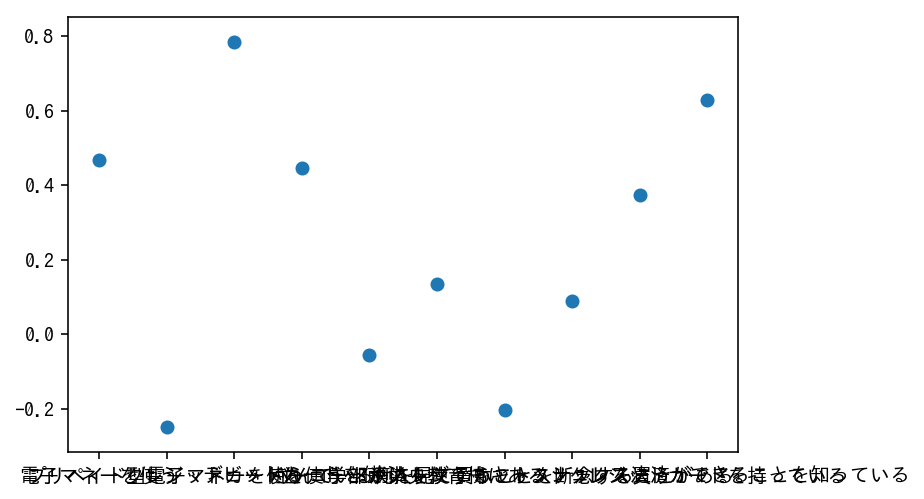

In [58]:
plt.scatter(loading_data1['特徴量'], loading_data1['pc1'])

- クレジットカードを持っている，使うと強い正の相関

- 第二主成分

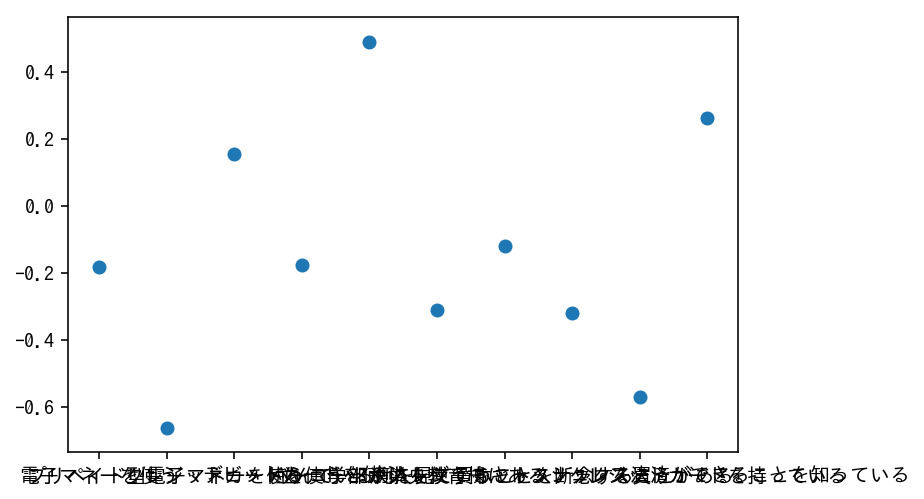

In [59]:
plt.scatter(loading_data1['特徴量'], loading_data1['pc2'])

- プリペイド型電子マネーと負の相関
- バーコード決済と正の相関

- 完全なる僕の推測だが，この分析1からわかるのは，オレンジのクラスタが集合しているということで，つまりクラス2; キャッシュレス決済手段を持っていながら，キャッシュレス決済を使用しないという人たち
- そういう人たちにどういうった特徴があるかというと，まず，第一主成分に対して，負の位置にクラスタが位置しており，第二主成分に対して，比較的正の位置にクラスタが位置している．つまり，クレジットカードを持たず，交通系電子マネーを持っていない人がこのクラスタに属するという推測が立てられる．

In [60]:
# プロット用関数の定義
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):
    # マーカーとカラーマップの用意
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # 決定領域のプロット
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    # グリッドポイントの生成
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                          np.arange(x2_min, x2_max, resolution))
    #各特徴量を1次元配列に変換して予測を実行
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    # 予測結果を元のグリッドポイントのデータサイズに変換
    Z = Z.reshape(xx1.shape)
    # グリッドポイントの等高線のプロット
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    # 軸の範囲の指定
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # クラスごとにサンプルをプロット
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.8, c=cmap(idx),
                   marker=markers[idx], label=cl)

- ロジスティック回帰（線形分離できなさそうなので意味ない）

In [61]:
from sklearn.preprocessing import StandardScaler

# データの標準化処理
sc = StandardScaler()
sc.fit(X1)
X1_std = sc.transform(X1)

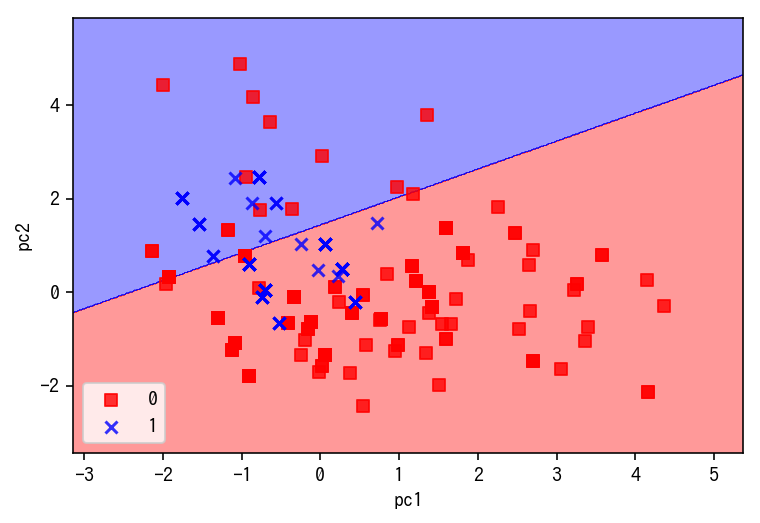

In [62]:
from sklearn.linear_model import LogisticRegression
# インスタンス生成
pca = PCA(n_components=2)
lr = LogisticRegression()

# 主成分分析
X1_pca = pca.fit_transform(X1_std)

# ロジスティック回帰
lr.fit(X1_pca, list(y1))

plot_decision_regions(X1_pca, y1, classifier=lr)
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.legend(loc='lower left')
plt.show()

- 線形分離が厳しそうなので**カーネルSVM**を使って分類を行ってみる

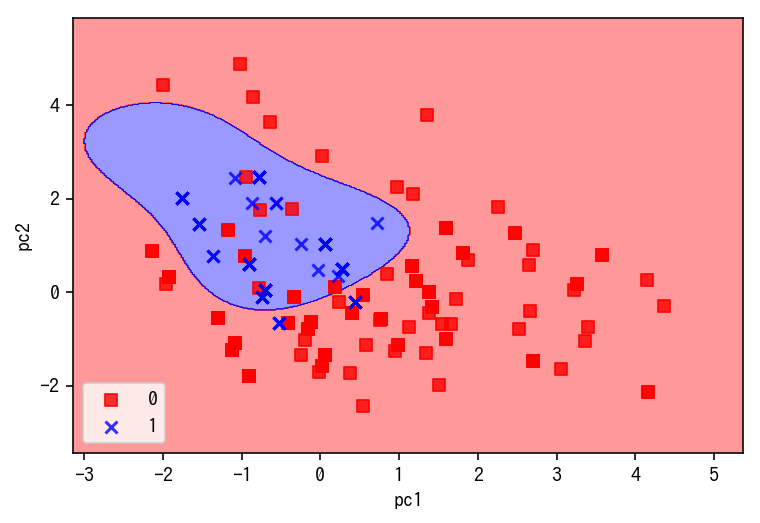

In [63]:
from sklearn.svm import SVC
rbf_svc = SVC(C=100, gamma=0.1, kernel='rbf')
rbf_svc.fit(X1_pca, list(y1))
plot_decision_regions(X1_pca, y1, classifier=rbf_svc)
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.legend(loc='lower left')
plt.show()

### 分析2

In [64]:
X2 = X2.drop(0, axis=1)

In [65]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
data_sc_2 = sc.fit_transform(X2)
pca = PCA(n_components=2)
pca.fit(data_sc_2)

transformed2 = pca.fit_transform(data_sc_2)

Text(0,0.5,'pc2')

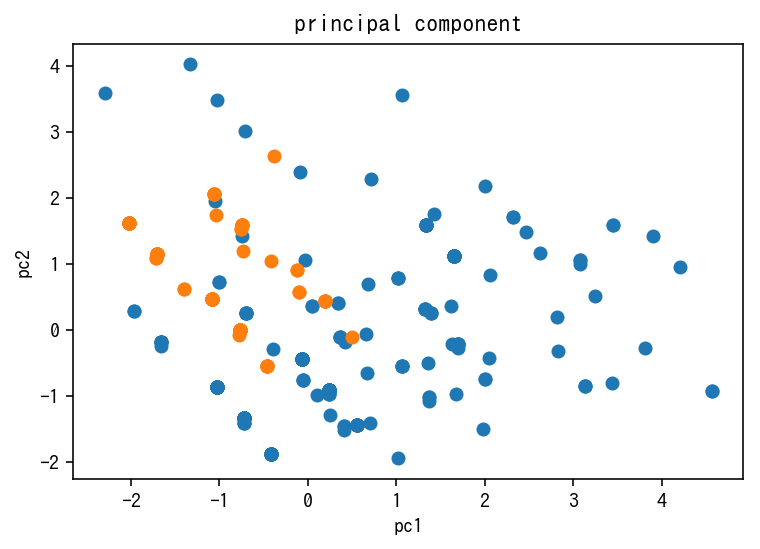

In [66]:
# 主成分をプロットする
for label in np.unique(y2):
    plt.scatter(transformed2[y2 == label, 0],
                transformed2[y2 == label, 1])
plt.title('principal component')
plt.xlabel('pc1')
plt.ylabel('pc2')

# 青がクラス1，オレンジがクラス2

In [67]:
index_X1

['電子マネーを使う',
 'プリペイド型電子マネーを使う',
 'クレジットカードを使う',
 'デビットカードを使う',
 'バーコード決済を使う',
 '学部が中央教育棟にある',
 '並んでいる列を見て買うことを断念することがある',
 'ホットスナックを買う',
 '有人レジでもキャッシュレス決済ができることを知っている',
 'クレジットカードを持っている']

In [68]:
# 因子負荷量の算出
loading2 = pca.components_ * np.c_[np.sqrt(pca.explained_variance_)]

# インデックスと固有ベクトルを対応させる
loading_data2 = pd.DataFrame({
    '特徴量': index_X1
    ,'pc1' : loading2[0]
    ,'pc2' : loading2[1]
})

- 第一主成分

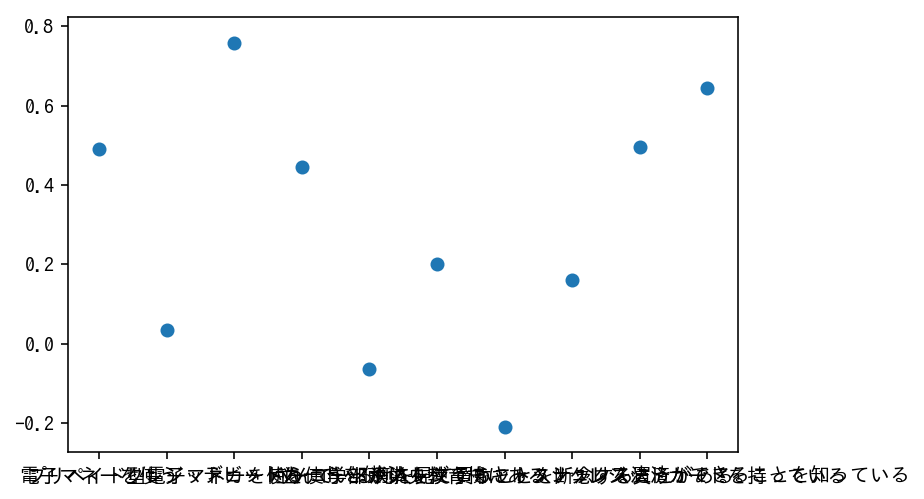

In [69]:
plt.scatter(loading_data2['特徴量'], loading_data2['pc1'])

- クレジットカードと強い正の相関

- 第二主成分

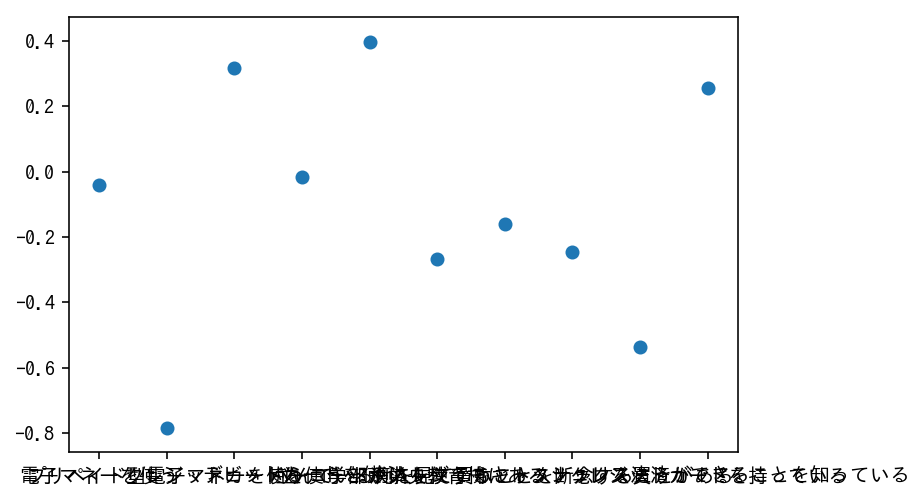

In [70]:
plt.scatter(loading_data2['特徴量'], loading_data2['pc2'])

- 交通系電子マネーと負の相関

- 分析1とほぼ同じ．
- クレカを持たず，電子マネーを持たないクラスタがオレンジ．

In [71]:
from sklearn.preprocessing import StandardScaler

# データの標準化処理
sc = StandardScaler()
sc.fit(X2)
X2_std = sc.transform(X2)

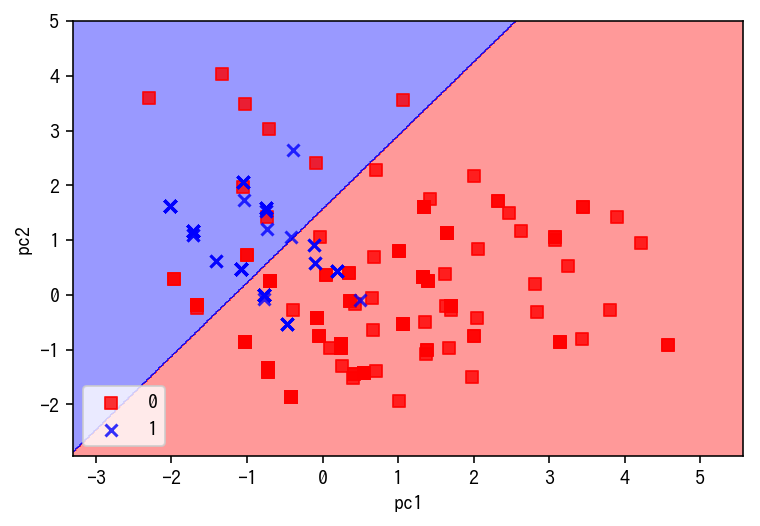

In [72]:
from sklearn.linear_model import LogisticRegression
# インスタンス生成
pca = PCA(n_components=2)
lr = LogisticRegression()

# 主成分分析
X2_pca = pca.fit_transform(X2_std)

# ロジスティック回帰
lr.fit(X2_pca, list(y2))

plot_decision_regions(X2_pca, y2, classifier=lr)
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.legend(loc='lower left')
plt.show()

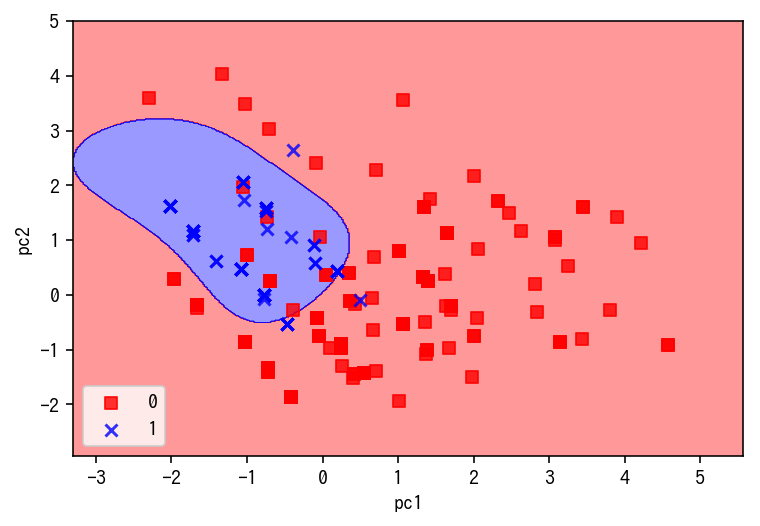

In [73]:
from sklearn.svm import SVC
rbf_svc = SVC(C=100, gamma=0.1, kernel='rbf')
rbf_svc.fit(X2_pca, list(y2))
plot_decision_regions(X2_pca, y2, classifier=rbf_svc)
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.legend(loc='lower left')
plt.show()

### 分析3

In [74]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
data_sc_3 = sc.fit_transform(X3)
pca = PCA(n_components=2)
pca.fit(data_sc_3)

transformed3 = pca.fit_transform(data_sc_3)

Text(0,0.5,'pc2')

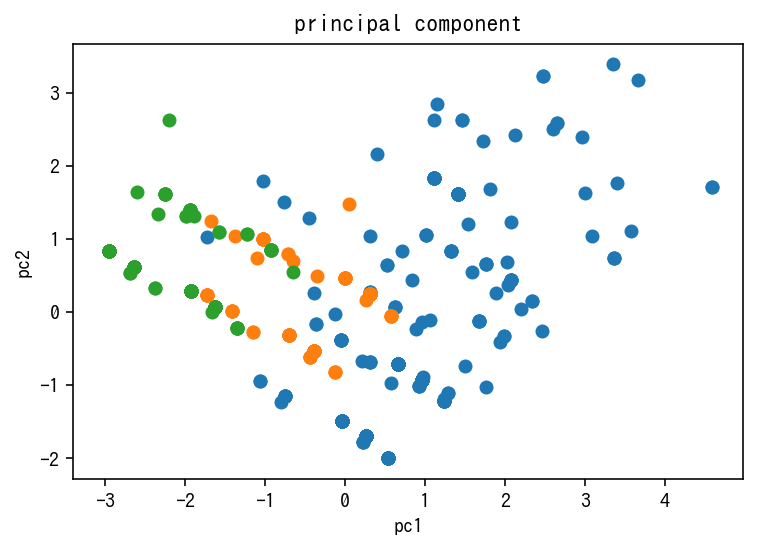

In [75]:
# 主成分をプロットする
for label in np.unique(y3):
    plt.scatter(transformed3[y3 == label, 0],
                transformed3[y3 == label, 1])
plt.title('principal component')
plt.xlabel('pc1')
plt.ylabel('pc2')

# 青がクラス1，オレンジがクラス2

In [76]:
# 因子負荷量の算出
loading3 = pca.components_ * np.c_[np.sqrt(pca.explained_variance_)]

# インデックスと固有ベクトルを対応させる
loading_data3 = pd.DataFrame({
    '特徴量': index_X
    ,'pc1' : loading3[0]
    ,'pc2' : loading3[1]
})

- 第一主成分

In [77]:
index_X

['キャッシュレス決済手段を持っていない',
 '電子マネーを使う',
 'プリペイド型電子マネーを使う',
 'クレジットカードを使う',
 'デビットカードを使う',
 'バーコード決済を使う',
 '学部が中央教育棟にある',
 '並んでいる列を見て買うことを断念することがある',
 'ホットスナックを買う',
 '有人レジでもキャッシュレス決済ができることを知っている',
 'クレジットカードを持っている']

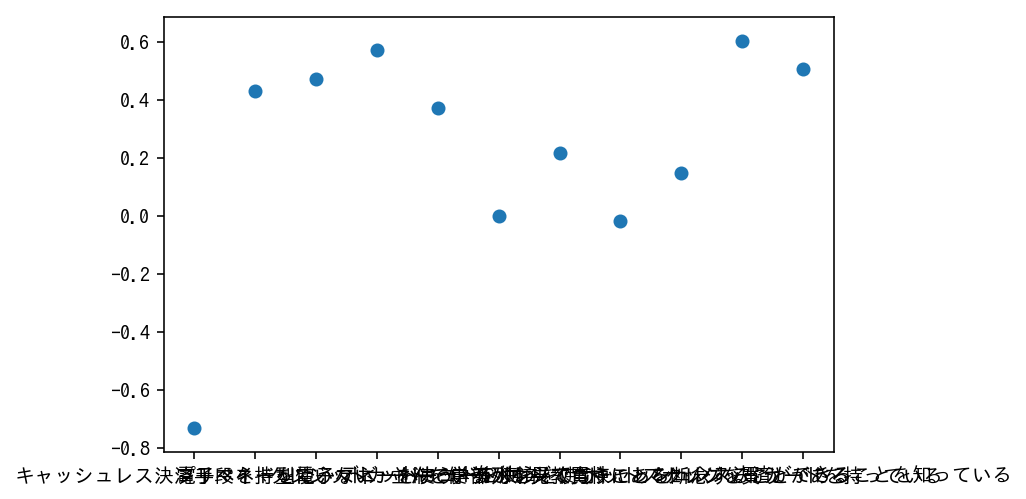

In [78]:
plt.scatter(loading_data3['特徴量'], loading_data3['pc1'])

- キャッシュレス決済手段を持っていないと強い負の相関
- クレジットカードと正の相関

- 第二主成分

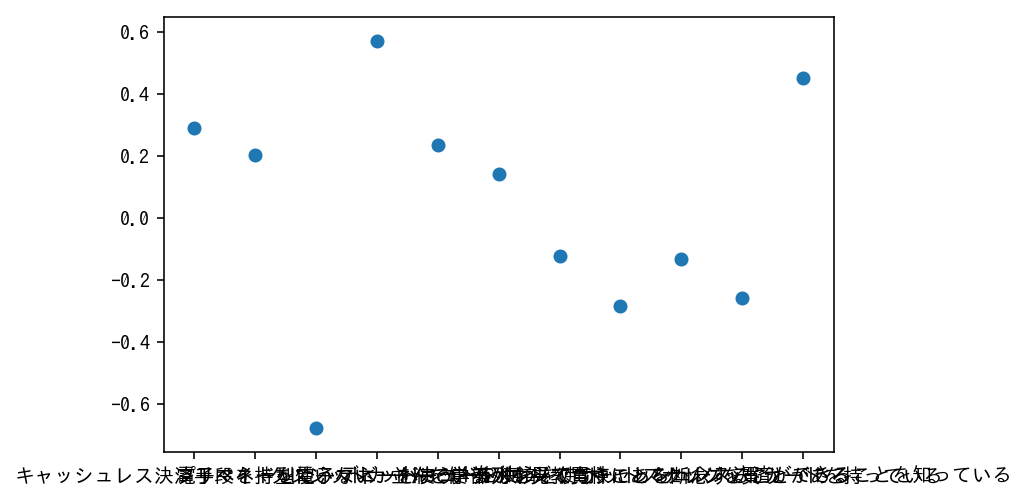

In [79]:
plt.scatter(loading_data3['特徴量'], loading_data3['pc2'])

- 交通系電子マネーと負の相関
- クレカと正の相関

#### ロジスティック回帰

In [80]:
from sklearn.preprocessing import StandardScaler

# データの標準化処理
sc = StandardScaler()
sc.fit(X3)
X3_std = sc.transform(X3)

# 主成分分析
from sklearn.decomposition import PCA, KernelPCA
# 主成分分析
pca = PCA(n_components=2)
X3_pca = pca.fit_transform(X3_std)

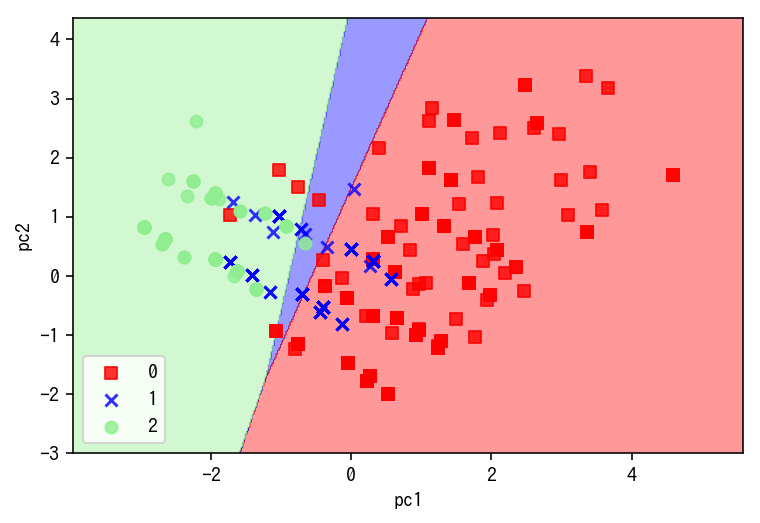

In [81]:
# ロジスティック回帰
lr.fit(X3_pca, list(y3))

plot_decision_regions(X3_pca, y3, classifier=lr)
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.legend(loc='lower left')
plt.show()

#### SVM; サポートベクターマシンを使った分類

In [82]:
from sklearn.svm import SVC
svm = SVC(kernel='linear', C=1.0, random_state=0)
svm.fit(X3_pca, list(y3))

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

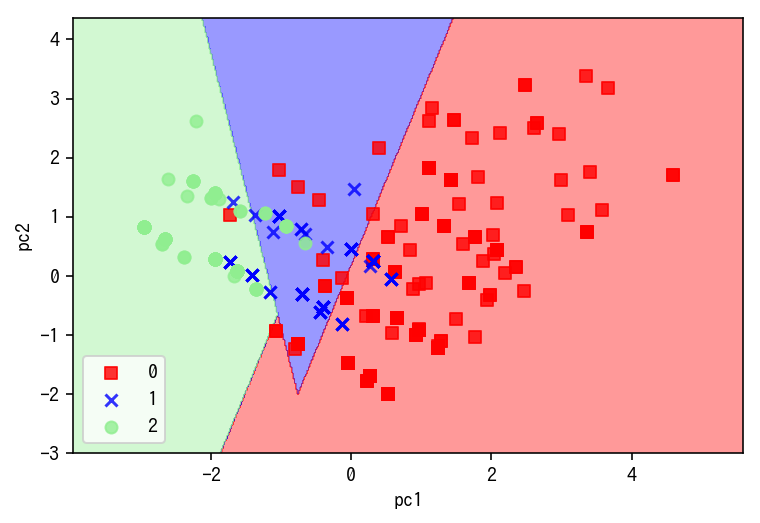

In [83]:
plot_decision_regions(X3_pca, y3, classifier=svm)
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.legend(loc='lower left')
plt.show()

- **線形分離が不可能そう..?**
- **非線形の分離をカーネルトリックを使用して解こう！**

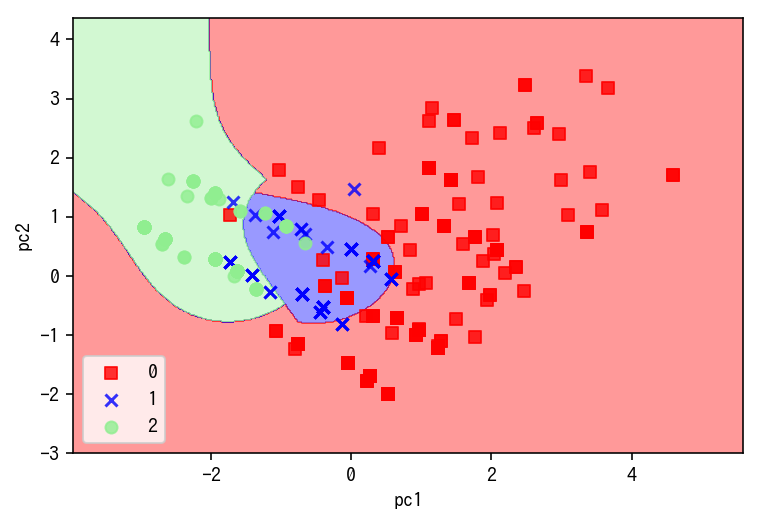

In [84]:
from sklearn.svm import SVC
rbf_svc = SVC(C=100, gamma=0.1, kernel='rbf')
rbf_svc.fit(X3_pca, list(y3))
plot_decision_regions(X3_pca, y3, classifier=rbf_svc)
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.legend(loc='lower left')
plt.show()

- 第一主成分軸では，キャッシュレス決済手段を持っていないと負の相関があるため，キャッシュレス決済手段を持っていないクラスタは必然的に左による
- 第二主成分軸では，「プリペイド型電子マネーを使わず，クレカを使う」と正の相関

## カーネル主成分分析を使った次元圧縮
---

##### カーネル主成分分析

In [85]:
# カーネル主成分分析
kpca = KernelPCA(n_components=2, kernel='rbf', fit_inverse_transform=True, gamma=0.02)
X3_kpca = kpca.fit_transform(X3_std)

In [86]:
X3_kpca[:10]

array([[-0.02606264, -0.05514545],
       [-0.0226873 ,  0.44075516],
       [-0.04381605,  0.41646216],
       [-0.44305978,  0.13097202],
       [ 0.02956014, -0.07909712],
       [ 0.0004593 ,  0.43406082],
       [-0.39750392,  0.11286485],
       [ 0.11693413, -0.30345216],
       [-0.36581518,  0.13560278],
       [ 0.19351619,  0.24562387]])

- 主成分のプロット

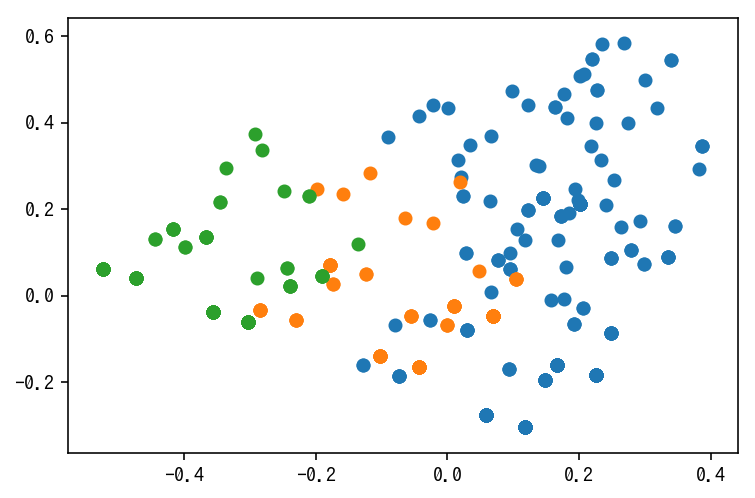

In [87]:
plt.scatter(X3_kpca[y3==0,0],X3_kpca[y3==0,1])
plt.scatter(X3_kpca[y3==1,0],X3_kpca[y3==1,1])
plt.scatter(X3_kpca[y3==2,0],X3_kpca[y3==2,1])

- svmにかける前にハイパーパラメータの調整を行う

In [88]:
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

pipe_svc = Pipeline([('scl', StandardScaler()), ('pca', KernelPCA(n_components=2)),
                    ('clf', SVC(random_state=1))])
param_range = [0.0001, 0.001, 0.01, 0.05, 0.1, 1.0, 10.0, 100.0, 500.0]
param_grid = [{'pca__alpha':param_range, 'pca__gamma':param_range}, 
              {'clf__C':param_range, 'clf__gamma':param_range, 'clf__kernel':['linear']},
              {'clf__C':param_range, 'clf__gamma':param_range, 'clf__kernel':['rbf']}]

gs = GridSearchCV(estimator=pipe_svc,
                 param_grid=param_grid,
                 scoring='accuracy',
                 cv=10,
                 n_jobs=-1)
gs = gs.fit(X3, list(y3))
print(gs.best_score_)
print(gs.best_params_)

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


0.9660194174757282
{'clf__C': 500.0, 'clf__gamma': 100.0, 'clf__kernel': 'rbf'}


- ガウスカーネルsvm

In [89]:
rbf_svc = SVC(C=500, gamma=100, kernel='rbf')
rbf_svc.fit(X3_kpca, list(y3))

SVC(C=500, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=100, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

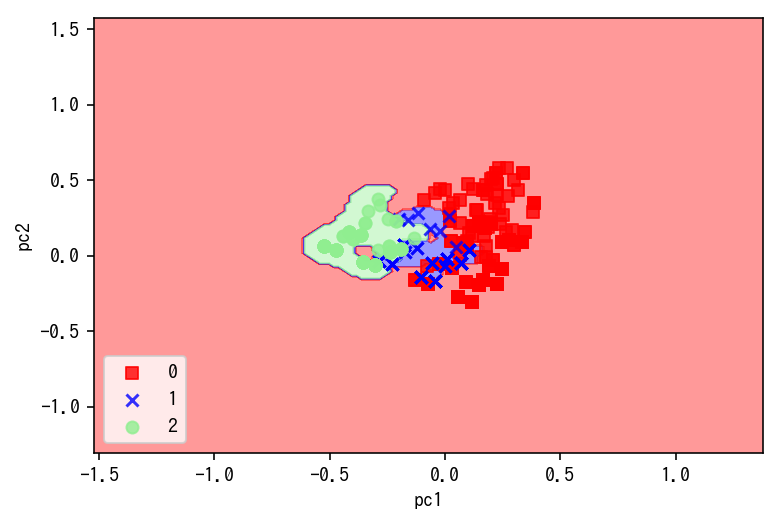

In [90]:
plot_decision_regions(X3_kpca, y3, classifier=rbf_svc)
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.legend(loc='lower left')
plt.show()

- 割とうまく分離できているのでは...?
- カーネル主成分分析による主成分に対する因子の負荷量がわからない

## 決定木学習
---

In [91]:
X_tree = XX.values
y_tree = list(y3)

from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy',max_depth=3, random_state=0)
# 学習
tr = tree.fit(X_tree, y_tree)

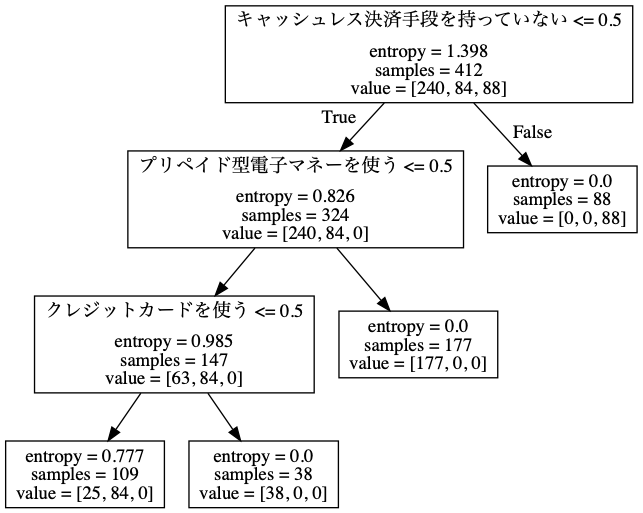

In [92]:
#可視化
import pydotplus
from IPython.display import Image
from sklearn.tree import export_graphviz
from graphviz import Digraph
from sklearn.externals.six import StringIO

dot_data = StringIO()
export_graphviz(tr, out_file=dot_data,feature_names=index_XX, max_depth=3)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_pdf("graph.pdf")
Image(graph.create_png())

- ジニ係数でも試してみる

In [93]:
# ジニ係数でも試してみる
tree_gini = DecisionTreeClassifier(criterion='gini',max_depth=3, random_state=0)
# 学習
tr = tree_gini.fit(X_tree, y_tree)

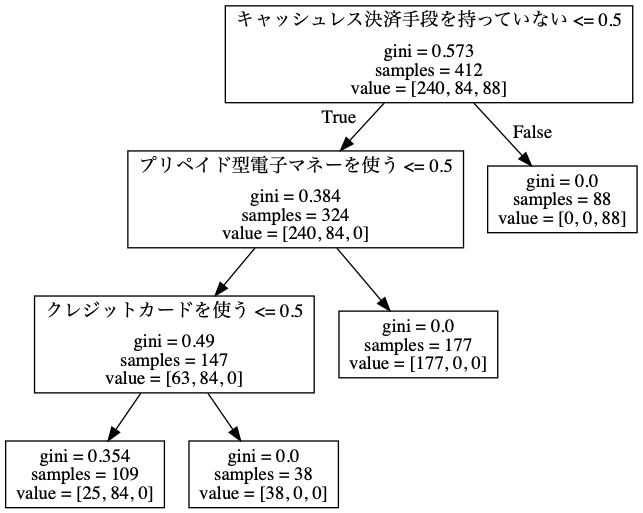

In [94]:
#可視化
import pydotplus
from IPython.display import Image
from sklearn.tree import export_graphviz
from graphviz import Digraph
from sklearn.externals.six import StringIO

dot_data = StringIO()
export_graphviz(tr, out_file=dot_data,feature_names=index_XX, max_depth=3)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_pdf("graph.pdf")
Image(graph.create_png())

## 検定
---


- 特徴量の有意性，また，線形回帰による統計量の確認を行う

In [95]:
i = [v for k,v in index_dict.items()]

In [96]:
i

['キャッシュレス決済手段を持っていない',
 '電子マネーを使う',
 'プリペイド型電子マネーを使う',
 'クレジットカードを使う',
 'デビットカードを使う',
 'バーコード決済を使う',
 '学部が中央教育棟にある',
 '並んでいる列を見て買うことを断念することがある',
 'ホットスナックを買う',
 '有人レジでもキャッシュレス決済ができることを知っている',
 'クレジットカードを持っている']

In [97]:
y = pd.DataFrame(y3)
y.columns = ["y"]

X = X3
X.columns = i

In [98]:
d = pd.concat([y, X], axis=1)
d = d.astype(float)

#### 重回帰分析

In [99]:
import statsmodels.api as sm

In [100]:
X = d.drop('y', 1)
X = sm.add_constant(X)
y = d['y']

In [101]:
model = sm.OLS(y,X)

In [102]:
result = model.fit()

In [103]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     455.1
Date:                Wed, 21 Nov 2018   Prob (F-statistic):          2.21e-218
Time:                        18:30:41   Log-Likelihood:                 37.389
No. Observations:                 412   AIC:                            -50.78
Df Residuals:                     400   BIC:                            -2.525
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           0.8032      0.056     14.327      0.000       0.693       0.913
キャッシュレス決済手段を持っていない              1.2348      0.033     37.141      0.000       1.169       1.300
電子マネーを使う                       -0.2820      0.039     -7.173      0.000      -0.359      -0.205
プリペイド型電子マネーを使う                 -0.6565      0.026    -25.242      0.000      -0.708      -0.605
クレジットカードを使う                    -0.4058      0.036    -11.245      0.000      -0.477      -0.335
デビットカードを使う                     -0.1599      0.055     -2.909      0.004      -0.268      -0.052
バーコード決済を使う                     -0.5657      0.073     -7.702      0.000      -0.710      -0.421
学部が中央教育棟にある                    -0.0100      0.023     -0.434      0.665      -0.055       0.035
並んでいる列を見て買うことを断念することがある        -0.0259      0.047     -0.547      0.585      -0.119       0.067
ホットスナックを買う                      0.0797      0.029      2.756      0.006       0.023       0.137
有人レジでもキャッシュレス決済ができることを知っている    -0.0491      0.030     -1.637      0.102      -0.108       0.010
クレジットカードを持っている                  0.0176      0.025      0.715      0.475      -0.031       0.066
==============================================================================
Omnibus:                        6.976   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.031   Jarque-Bera (JB):                9.208
Skew:                           0.137   Prob(JB):                       0.0100
Kurtosis:                       3.679   Cond. No.                         12.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- ここで，p値の低かった変数下位5つをのぞいて回帰分析を再度行ってみる．

In [104]:
type(y)

pandas.core.series.Series

In [105]:
X = X.drop(columns=["学部が中央教育棟にある", "並んでいる列を見て買うことを断念することがある", "クレジットカードを持っている"])

In [106]:
model2 = sm.OLS(y,X)

In [107]:
result2 = model2.fit()

In [108]:
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     628.9
Date:                Wed, 21 Nov 2018   Prob (F-statistic):          2.41e-222
Time:                        18:30:43   Log-Likelihood:                 36.917
No. Observations:                 412   AIC:                            -55.83
Df Residuals:                     403   BIC:                            -19.64
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           0.7836      0.031     25.117      0.000       0.722       0.845
キャッシュレス決済手段を持っていない              1.2310      0.033     37.653      0.000       1.167       1.295
電子マネーを使う                       -0.2785      0.039     -7.138      0.000      -0.355      -0.202
プリペイド型電子マネーを使う                 -0.6582      0.026    -25.449      0.000      -0.709      -0.607
クレジットカードを使う                    -0.3952      0.033    -11.803      0.000      -0.461      -0.329
デビットカードを使う                     -0.1635      0.055     -2.995      0.003      -0.271      -0.056
バーコード決済を使う                     -0.5653      0.073     -7.735      0.000      -0.709      -0.422
ホットスナックを買う                      0.0784      0.029      2.731      0.007       0.022       0.135
有人レジでもキャッシュレス決済ができることを知っている    -0.0518      0.030     -1.742      0.082      -0.110       0.007
==============================================================================
Omnibus:                        6.513   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.039   Jarque-Bera (JB):                8.446
Skew:                           0.130   Prob(JB):                       0.0147
Kurtosis:                       3.652   Cond. No.                         9.57
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [109]:
d.columns.values

array(['y', 'キャッシュレス決済手段を持っていない', '電子マネーを使う', 'プリペイド型電子マネーを使う',
       'クレジットカードを使う', 'デビットカードを使う', 'バーコード決済を使う', '学部が中央教育棟にある',
       '並んでいる列を見て買うことを断念することがある', 'ホットスナックを買う',
       '有人レジでもキャッシュレス決済ができることを知っている', 'クレジットカードを持っている'], dtype=object)

In [110]:
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

model3 = ols('y ~ {} + {} + {} + {} + {} + {} + {} + {} + {} + {} + {}'.format('キャッシュレス決済手段を持っていない', '電子マネーを使う', 'プリペイド型電子マネーを使う',
       'クレジットカードを使う', 'デビットカードを使う', 'バーコード決済を使う', '学部が中央教育棟にある',
       '並んでいる列を見て買うことを断念することがある', 'ホットスナックを買う',
       '有人レジでもキャッシュレス決済ができることを知っている', 'クレジットカードを持っている'), d).fit()

In [111]:
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     455.1
Date:                Wed, 21 Nov 2018   Prob (F-statistic):          2.21e-218
Time:                        18:30:44   Log-Likelihood:                 37.389
No. Observations:                 412   AIC:                            -50.78
Df Residuals:                     400   BIC:                            -2.525
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       0.8032      0.056     14.327      0.000       0.693       0.913
キャッシュレス決済手段を持っていない              1.2348      0.033     37.141      0.000       1.169       1.300
電子マネーを使う                       -0.2820      0.039     -7.173      0.000      -0.359      -0.205
プリペイド型電子マネーを使う                 -0.6565      0.026    -25.242      0.000      -0.708      -0.605
クレジットカードを使う                    -0.4058      0.036    -11.245      0.000      -0.477      -0.335
デビットカードを使う                     -0.1599      0.055     -2.909      0.004      -0.268      -0.052
バーコード決済を使う                     -0.5657      0.073     -7.702      0.000      -0.710      -0.421
学部が中央教育棟にある                    -0.0100      0.023     -0.434      0.665      -0.055       0.035
並んでいる列を見て買うことを断念することがある        -0.0259      0.047     -0.547      0.585      -0.119       0.067
ホットスナックを買う                      0.0797      0.029      2.756      0.006       0.023       0.137
有人レジでもキャッシュレス決済ができることを知っている    -0.0491      0.030     -1.637      0.102      -0.108       0.010
クレジットカードを持っている                  0.0176      0.025      0.715      0.475      -0.031       0.066
==============================================================================
Omnibus:                        6.976   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.031   Jarque-Bera (JB):                9.208
Skew:                           0.137   Prob(JB):                       0.0100
Kurtosis:                       3.679   Cond. No.                         12.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- 変数間の相関があることは間違いないためマルチコは否めない...
- 一応マルチコを調べておく．

In [112]:
data_x = d.drop(columns="y")

In [113]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(data_x.values, i) for i in range(data_x.shape[1])]
vif["features"] = data_x.columns

In [114]:
vif

,VIF Factor,features
0,1.687135,キャッシュレス決済手段を持っていない
1,1.194357,電子マネーを使う
2,2.319531,プリペイド型電子マネーを使う
3,1.562751,クレジットカードを使う
4,1.137322,デビットカードを使う
5,1.068650,バーコード決済を使う
6,2.461581,学部が中央教育棟にある
7,6.911416,並んでいる列を見て買うことを断念することがある
8,1.259728,ホットスナックを買う
9,5.034856,有人レジでもキャッシュレス決済ができることを知っている


### 信頼区間の算出
- キャッシュレス決済手段を使わない人が41.4%という値が本当に大丈夫なのか
- 400人の標本で大丈夫か

ということに関する担保を取るため，信頼区間を作っておく．

- 信頼区間は以下となる．

$ \hat{p} - 1.96 \sqrt{ \frac{ \hat{p} - ( 1 - \hat{p} ) }{n} } < p <  \hat{p} + 1.96 \sqrt{ \frac{ \hat{p} - ( 1 - \hat{p} ) }{n} }  $

#### キャッシュレス決済手段非使用者の検定
- ここでは，論文内で使用したデータのうち，40%の人がキャッシュレス決済手段を使用していないというデータの有意性の区間推定による担保を目的とする

In [115]:
from scipy import stats

p = 0.414
alpha_r = 0.05  # 有意水準設定
n = 412  # 標本のサンプル数
t = abs(stats.norm.ppf(alpha_r/2))

In [116]:
bottom = p - t * np.sqrt((p * (1 - p)) / n)

In [117]:
up = p + t * np.sqrt((p * (1 - p)) / n)

In [118]:
"キャッシュレス決済手段を使用しない人の割合の95%信頼区間 : [{0:.2f}, {1:.2f}]".format(bottom, up)

'キャッシュレス決済手段を使用しない人の割合の95%信頼区間 : [0.37, 0.46]'

#### 交通系電子マネー使用者の検定

In [119]:
p1 = 0.776
n1 = 219

bottom1 = p1 - t * np.sqrt((p1 * (1 - p1)) / n1)
up1 = p1 + t * np.sqrt((p1 * (1 - p1)) / n1)

In [120]:
"交通系電子マネーを使用している人の割合の95%信頼区間 : [{0:.2f}, {1:.2f}]".format(bottom1, up1)

'交通系電子マネーを使用している人の割合の95%信頼区間 : [0.72, 0.83]'